In [38]:
using CSV
using Dates
using DelimitedFiles 
using NCDatasets
using PyPlot
using DIVAnd
using Statistics
using PkgVersion
const plt=PyPlot

PyPlot

In [4]:
using PyCall
using PyPlot
colors = PyCall.pyimport("matplotlib.colors")
ccrs = PyCall.pyimport("cartopy.crs")
cfeature = PyCall.pyimport("cartopy.feature")
mticker = PyCall.pyimport("matplotlib.ticker")
coast = cfeature.GSHHSFeature(scale="full");
cartopyticker = PyCall.pyimport("cartopy.mpl.ticker")
lon_formatter = cartopyticker.LongitudeFormatter()
lat_formatter = cartopyticker.LatitudeFormatter()
# mainproj = ccrs.PlateCarree()
cmocean = PyCall.pyimport("cmocean")

mycolor = "#6667AB"
mycolor2 = "#456A30" # Green treetop
dom = [-22.5, 12.5, 40, 68.]
dlon = 5.
dlat = 5.
mainproj = ccrs.Mercator(central_longitude=0.5*(dom[1] + dom[2]),
    min_latitude=dom[3], max_latitude=dom[4])
datacrs = ccrs.PlateCarree();

In [95]:
datadir = "../data/"
figdir = "../figures"
resdir = "../results/"
isdir(resdir) ? @debug("already there") : mkpath(resdir)
isdir(figdir) ? @debug("already there") : mkpath(figdir)
datafile = joinpath(datadir, "MBA_CPRdata_Emodnet_21Jan22.csv")
isfile(datafile) ? @debug("already downloaded") : download("https://dox.ulg.ac.be/index.php/s/hjWKf1F3C1Pzz1r/download", datafile)
bathfile = joinpath(datadir, "gebco_30sec_16.nc")
isfile(datafile), isfile(bathfile)

(true, true)

## Grid configuration

In [6]:
Δlon = 0.1
Δlat = 0.1
longrid = dom[1]:Δlon:dom[2]
latgrid = dom[3]:Δlat:dom[4]

40.0:0.1:68.0

### Metrics

In [7]:
_, (pm, pn), (xi, yi) = DIVAnd_rectdom(longrid, latgrid);
@info(size(xi));

┌ Info: (351, 281)
└ @ Main In[7]:2


### Prepare mask

In [8]:
bx, by, b = DIVAnd.load_bath(bathfile, true, longrid, latgrid)
@show size(b)

size(b) = (351, 281)


(351, 281)

In [9]:
fig = plt.figure(figsize=(12, 12))
ax = plt.subplot(111, projection=mainproj)
pcm = ax.pcolormesh(bx, by, b', vmin=0., cmap=PyPlot.cm.gist_earth, transform=datacrs);
ax.add_feature(coast, facecolor="#363636", edgecolor="k", zorder=5)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=true,
                      linewidth=.5, color="gray", alpha=1, linestyle="--")
gl.top_labels = false
gl.right_labels = false
gl.xformatter = lon_formatter
gl.yformatter = lat_formatter
gl.xlabel_style = Dict("size" => 10)
gl.ylabel_style = Dict("size" => 10)

cb = plt.colorbar(pcm, orientation="vertical")
cb.set_label("Depth (m)", rotation=0, ha="left")
plt.savefig(joinpath(figdir, "domain_bathy_010"), dpi=300, bbox_inches="tight")
plt.close()

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall /home/ctroupin/.julia/packages/PyCall/3fwVL/src/numpy.jl:67


In [90]:
_, _, mask = DIVAnd.load_mask(bathfile, true, longrid, latgrid, 0.0);
# Remove Mediterranean Sea
mask[220:end,1:60] .= 0;

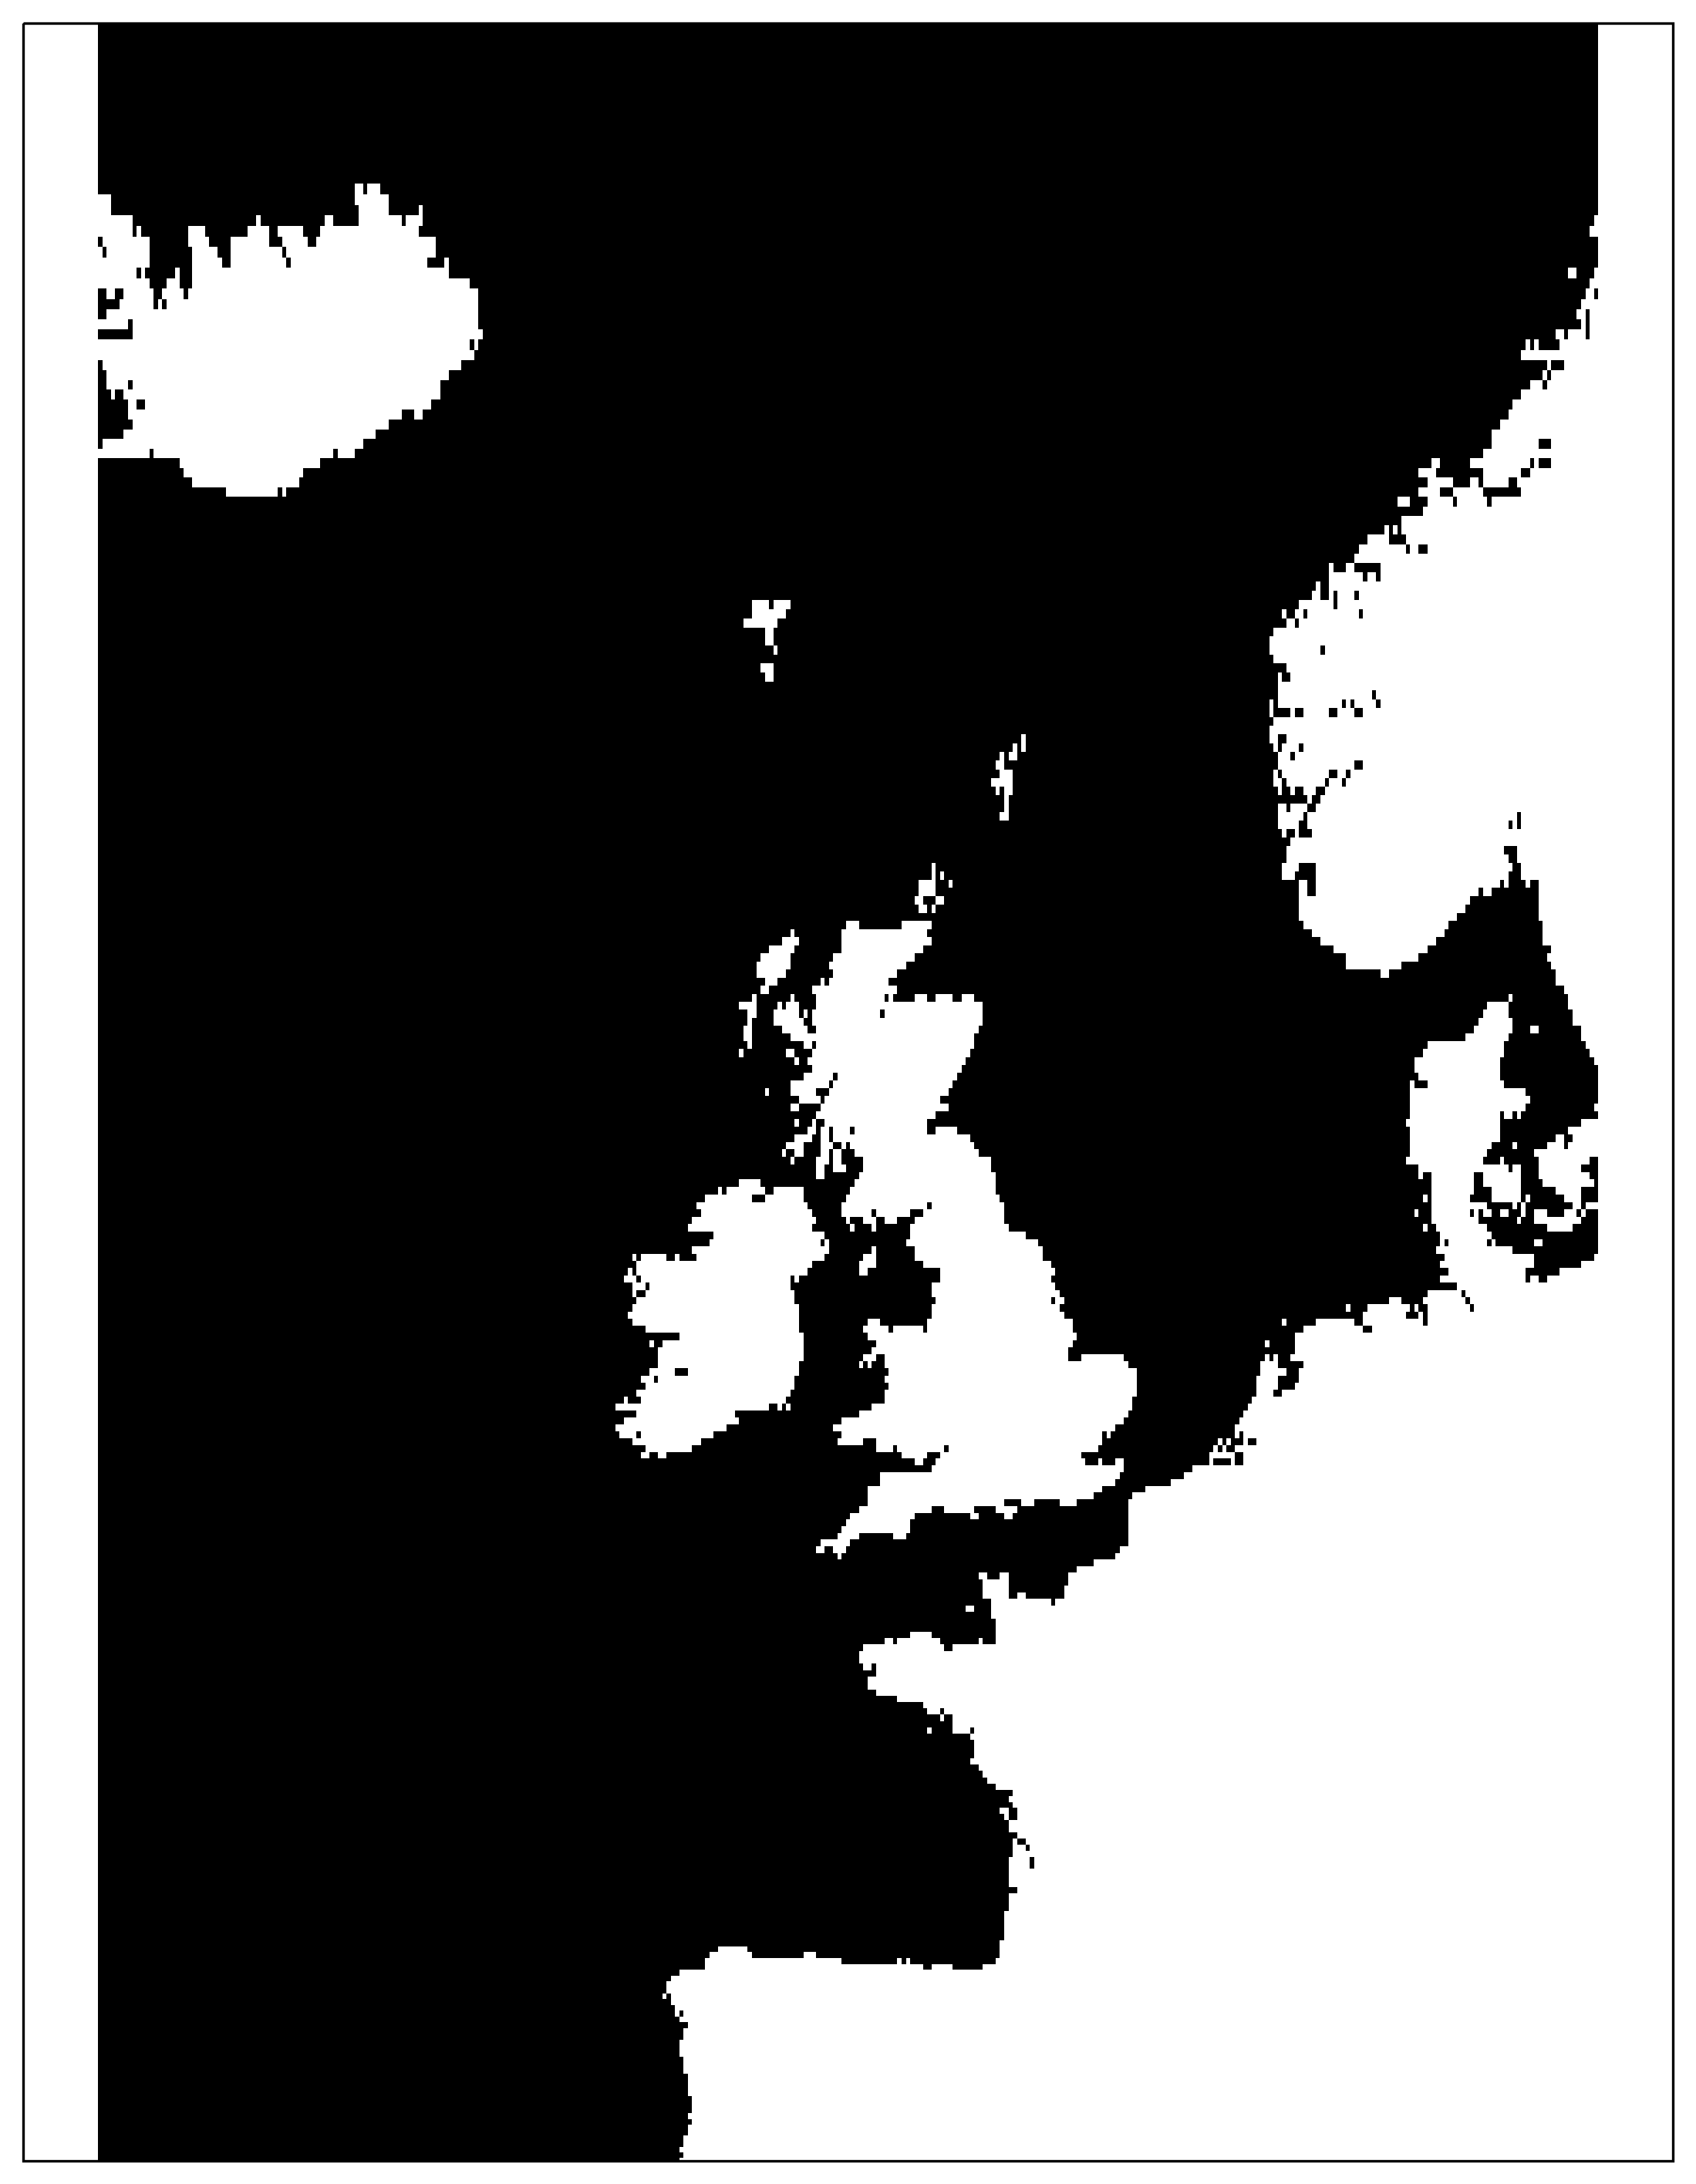

In [91]:
fig = plt.figure(figsize=(12, 12))
ax = plt.subplot(111, projection=mainproj)
pcm = ax.pcolormesh(bx, by, mask', cmap=PyPlot.cm.binary, transform=datacrs)
gl.top_labels = false
gl.right_labels = false
gl.xformatter = lon_formatter
gl.yformatter = lat_formatter
gl.xlabel_style = Dict("size" => 10)
gl.ylabel_style = Dict("size" => 10)

plt.savefig(joinpath(figdir, "domain_mask_011"), dpi=300, bbox_inches="tight")
plt.show()

## Data reading

In [12]:
data = readdlm(datafile, ',', skipstart=1);

In [13]:
lon = data[:,3]
lat = data[:,2]
year = data[:,4]
month = data[:,5]
thedates = Date.(year, month)
calanus_finmarchicus = data[:,6]
calanus_helgolandicus = data[:,7];

In [15]:
nyears = maximum(year) - minimum(year) + 1
@info(nyears)
yearcount = zeros(nyears);

┌ Info: 60
└ @ Main In[15]:2


60-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [16]:
function count_years_months(year::Array, month::Array)
    
    nyears = maximum(year) - minimum(year) + 1
    @info(nyears)
    yearcount = zeros(nyears)
    monthcount = zeros(12)
    
    ii = 0
    for yyyy in minimum(year):maximum(year)
        ii += 1
        yearcount[ii] = sum(year .== yyyy)
    end
    
    for mm in 1:12
        monthcount[mm] = sum(month .== mm)
    end
       
    return yearcount, monthcount
end

count_years_months (generic function with 1 method)

In [17]:
yearcount, monthcount = count_years_months(year, month);

┌ Info: 60
└ @ Main In[16]:4


### Year histogram

In [18]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
plt.bar(minimum(year):maximum(year), yearcount, color=mycolor)
plt.savefig(joinpath(figdir, "time_histogram_year"), dpi=300, bbox_inches="tight")
# plt.show()
plt.close()

### Month histogram

In [19]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111)
plt.bar(1:12, monthcount, color=mycolor)
ax.set_xticks(collect(1:12), Dates.monthname.(1:12))
fig.autofmt_xdate()
plt.savefig(joinpath(figdir, "time_histogram_month"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

### Polar

In [20]:
N = 12
theta = LinRange(0, 2 * π - π/6, N)
width = (1.8 * π) / N
fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111, polar=true)
ax.set_thetagrids(collect(0:30:330), Dates.monthname.(1:12))
ax.set_theta_zero_location("N")
bars = ax.bar(theta, monthcount, width=width, color=mycolor)
plt.savefig(joinpath(figdir, "time_histogram_month_polar"), dpi=300, bbox_inches="tight")
plt.close()

## Spatial distribution

In [21]:
fig = plt.figure(figsize=(12, 12))
ax = plt.subplot(111, projection=mainproj)
ax.plot(lon, lat, "ko", markersize=1, transform=datacrs)
ax.add_feature(coast, facecolor="#363636", edgecolor="k", zorder=5)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=true,
                      linewidth=.5, color="gray", alpha=1, linestyle="--")
gl.top_labels = false
gl.right_labels = false
gl.xformatter = lon_formatter
gl.yformatter = lat_formatter
gl.xlabel_style = Dict("size" => 10)
gl.ylabel_style = Dict("size" => 10)
ax.set_title("Locations of the observations")
plt.savefig(joinpath(figdir, "location_obs"), dpi=300, bbox_inches="tight")
plt.show()
plt.close()

### Finmarchicus

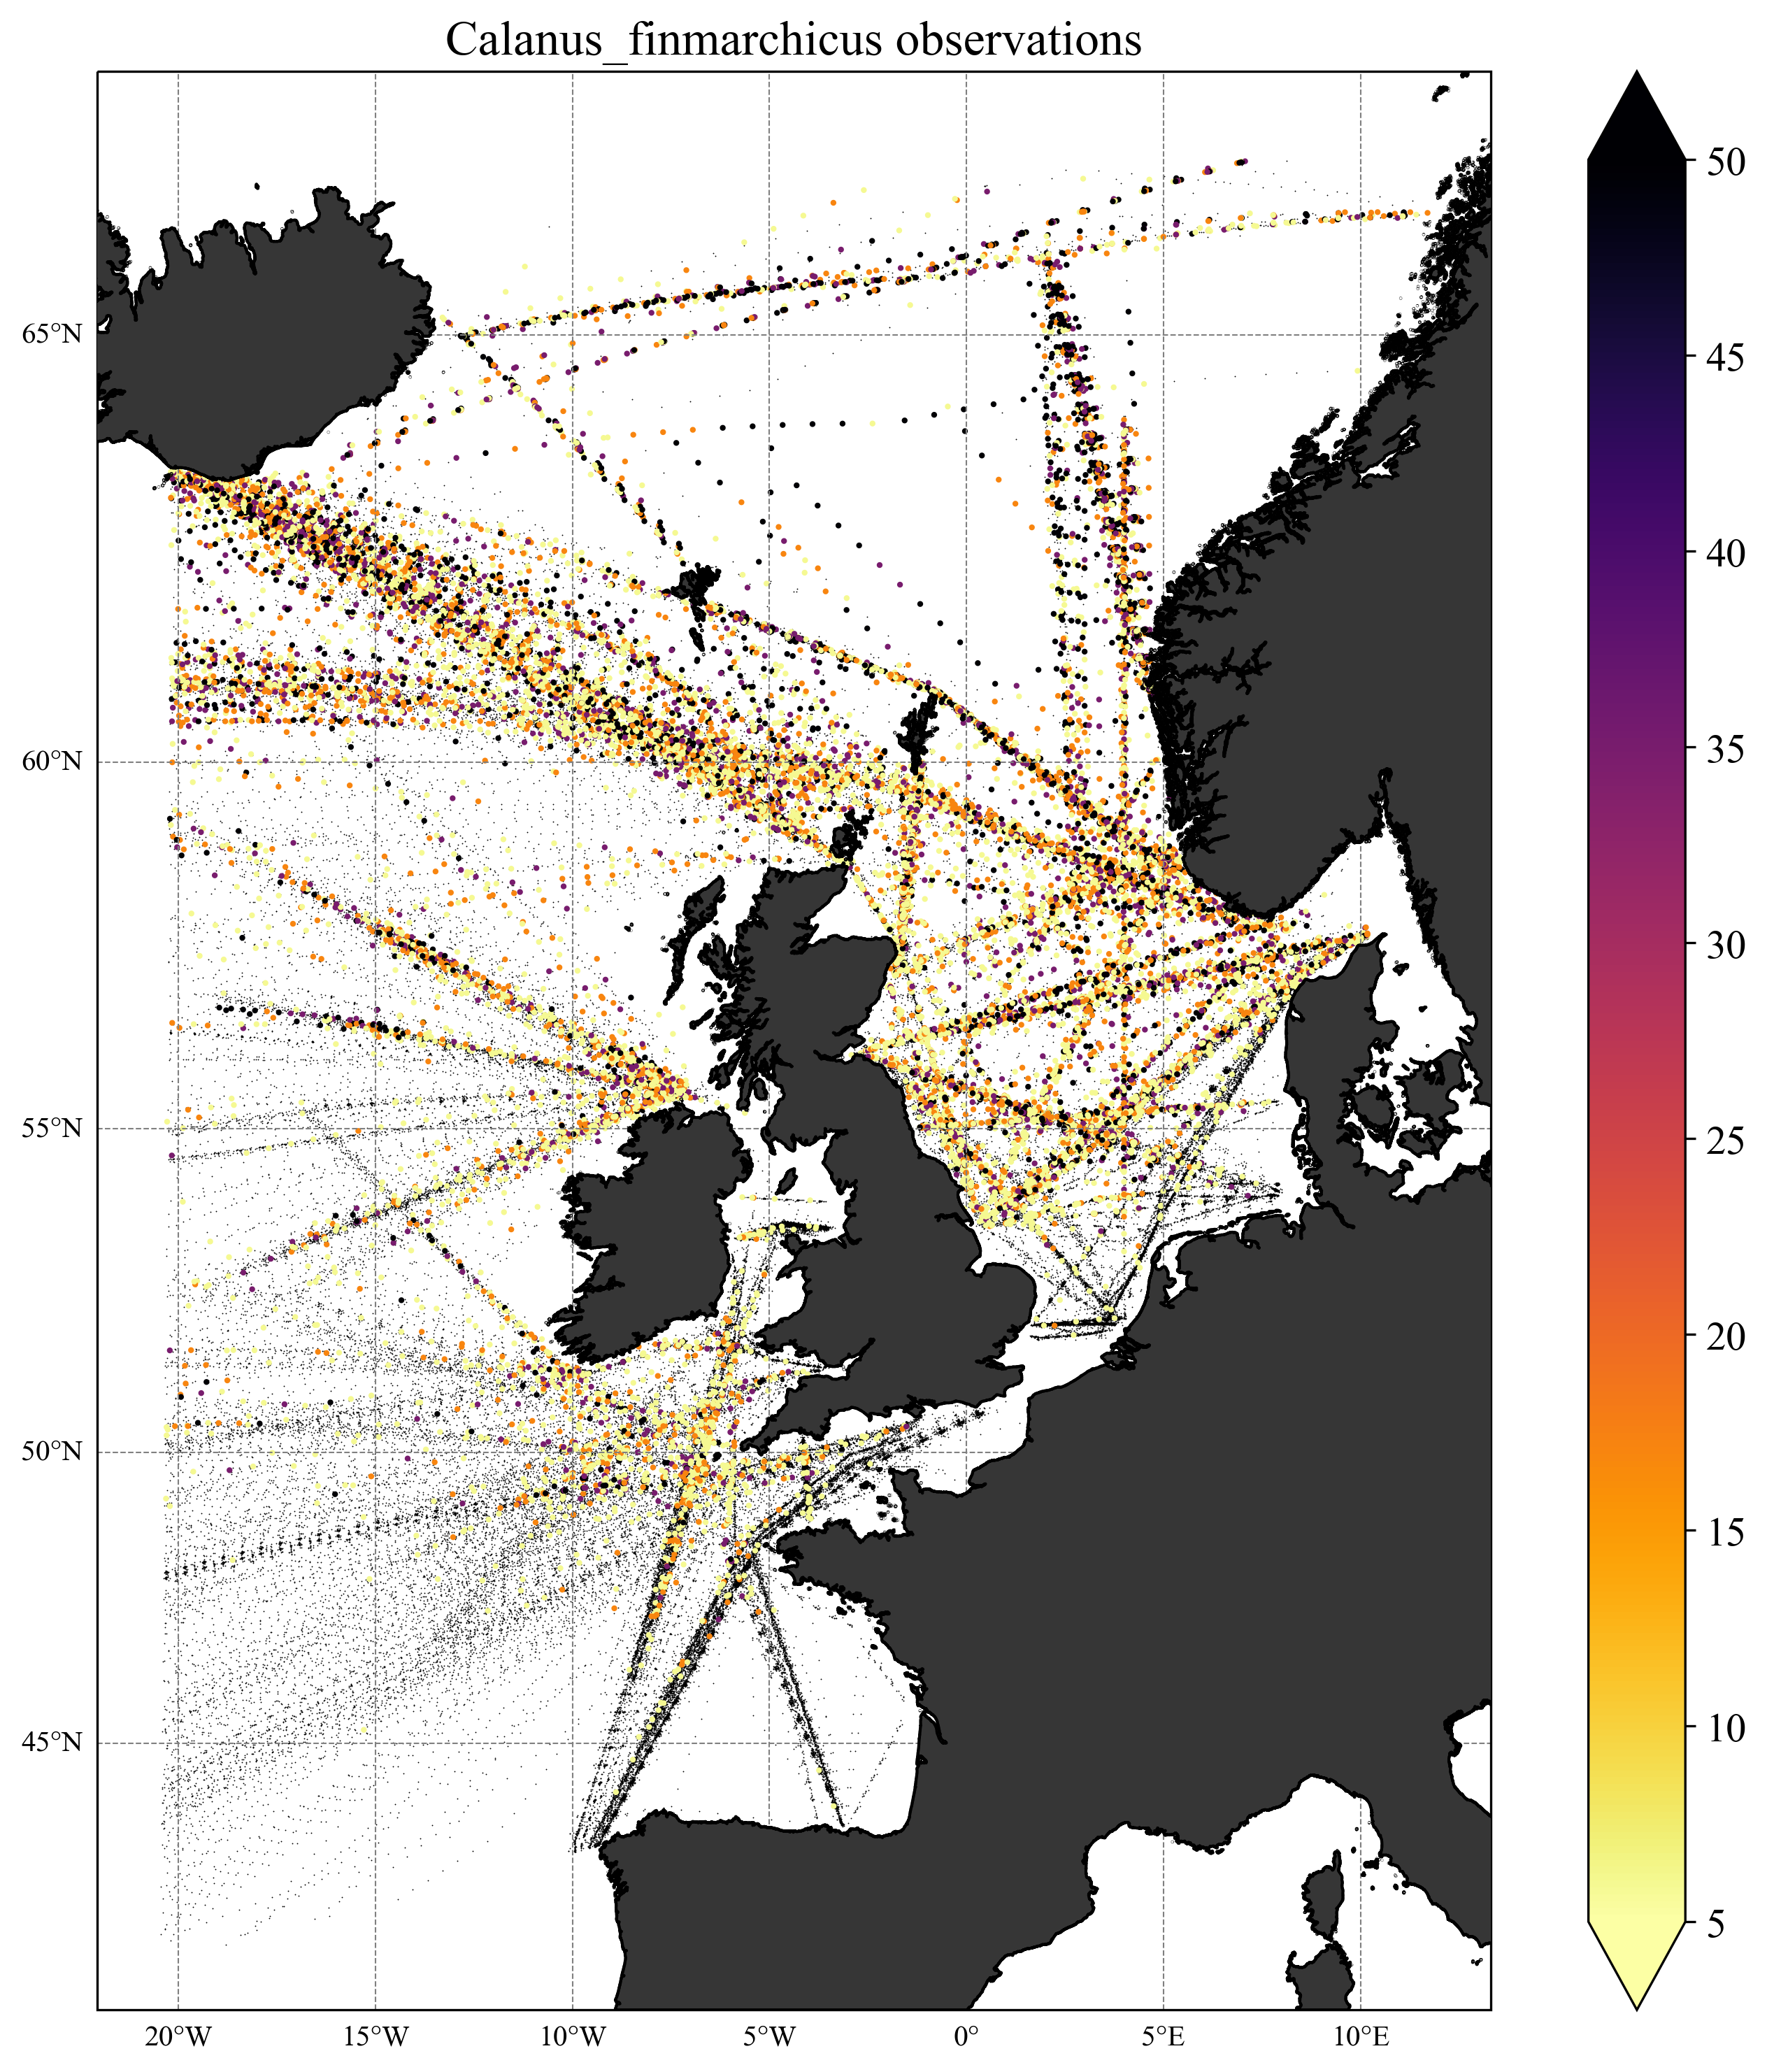

In [22]:
countmin = 5
fig = plt.figure(figsize=(12, 12))
ax = plt.subplot(111, projection=mainproj)
ax.scatter(lon, lat, s=.1, lw=.1, color="k", transform=datacrs)
indexplot = findall(calanus_finmarchicus .>= countmin)
scat = ax.scatter(lon[indexplot], lat[indexplot], s=1, c=calanus_finmarchicus[indexplot], 
                  cmap=plt.cm.inferno_r, vmin=countmin, vmax=50., transform=datacrs)

cb = plt.colorbar(scat, extend="both")

ax.add_feature(coast, facecolor="#363636", edgecolor="k", zorder=5)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=true,
                      linewidth=.5, color="gray", alpha=1, linestyle="--")
gl.top_labels = false
gl.right_labels = false
gl.xformatter = lon_formatter
gl.yformatter = lat_formatter
gl.xlabel_style = Dict("size" => 10)
gl.ylabel_style = Dict("size" => 10)
ax.set_title("Calanus_finmarchicus observations")

plt.savefig(joinpath(figdir, "count_calanus_finmarchicus2.jpg"), dpi=300, bbox_inches="tight")

plt.show()

#### Location of zeros

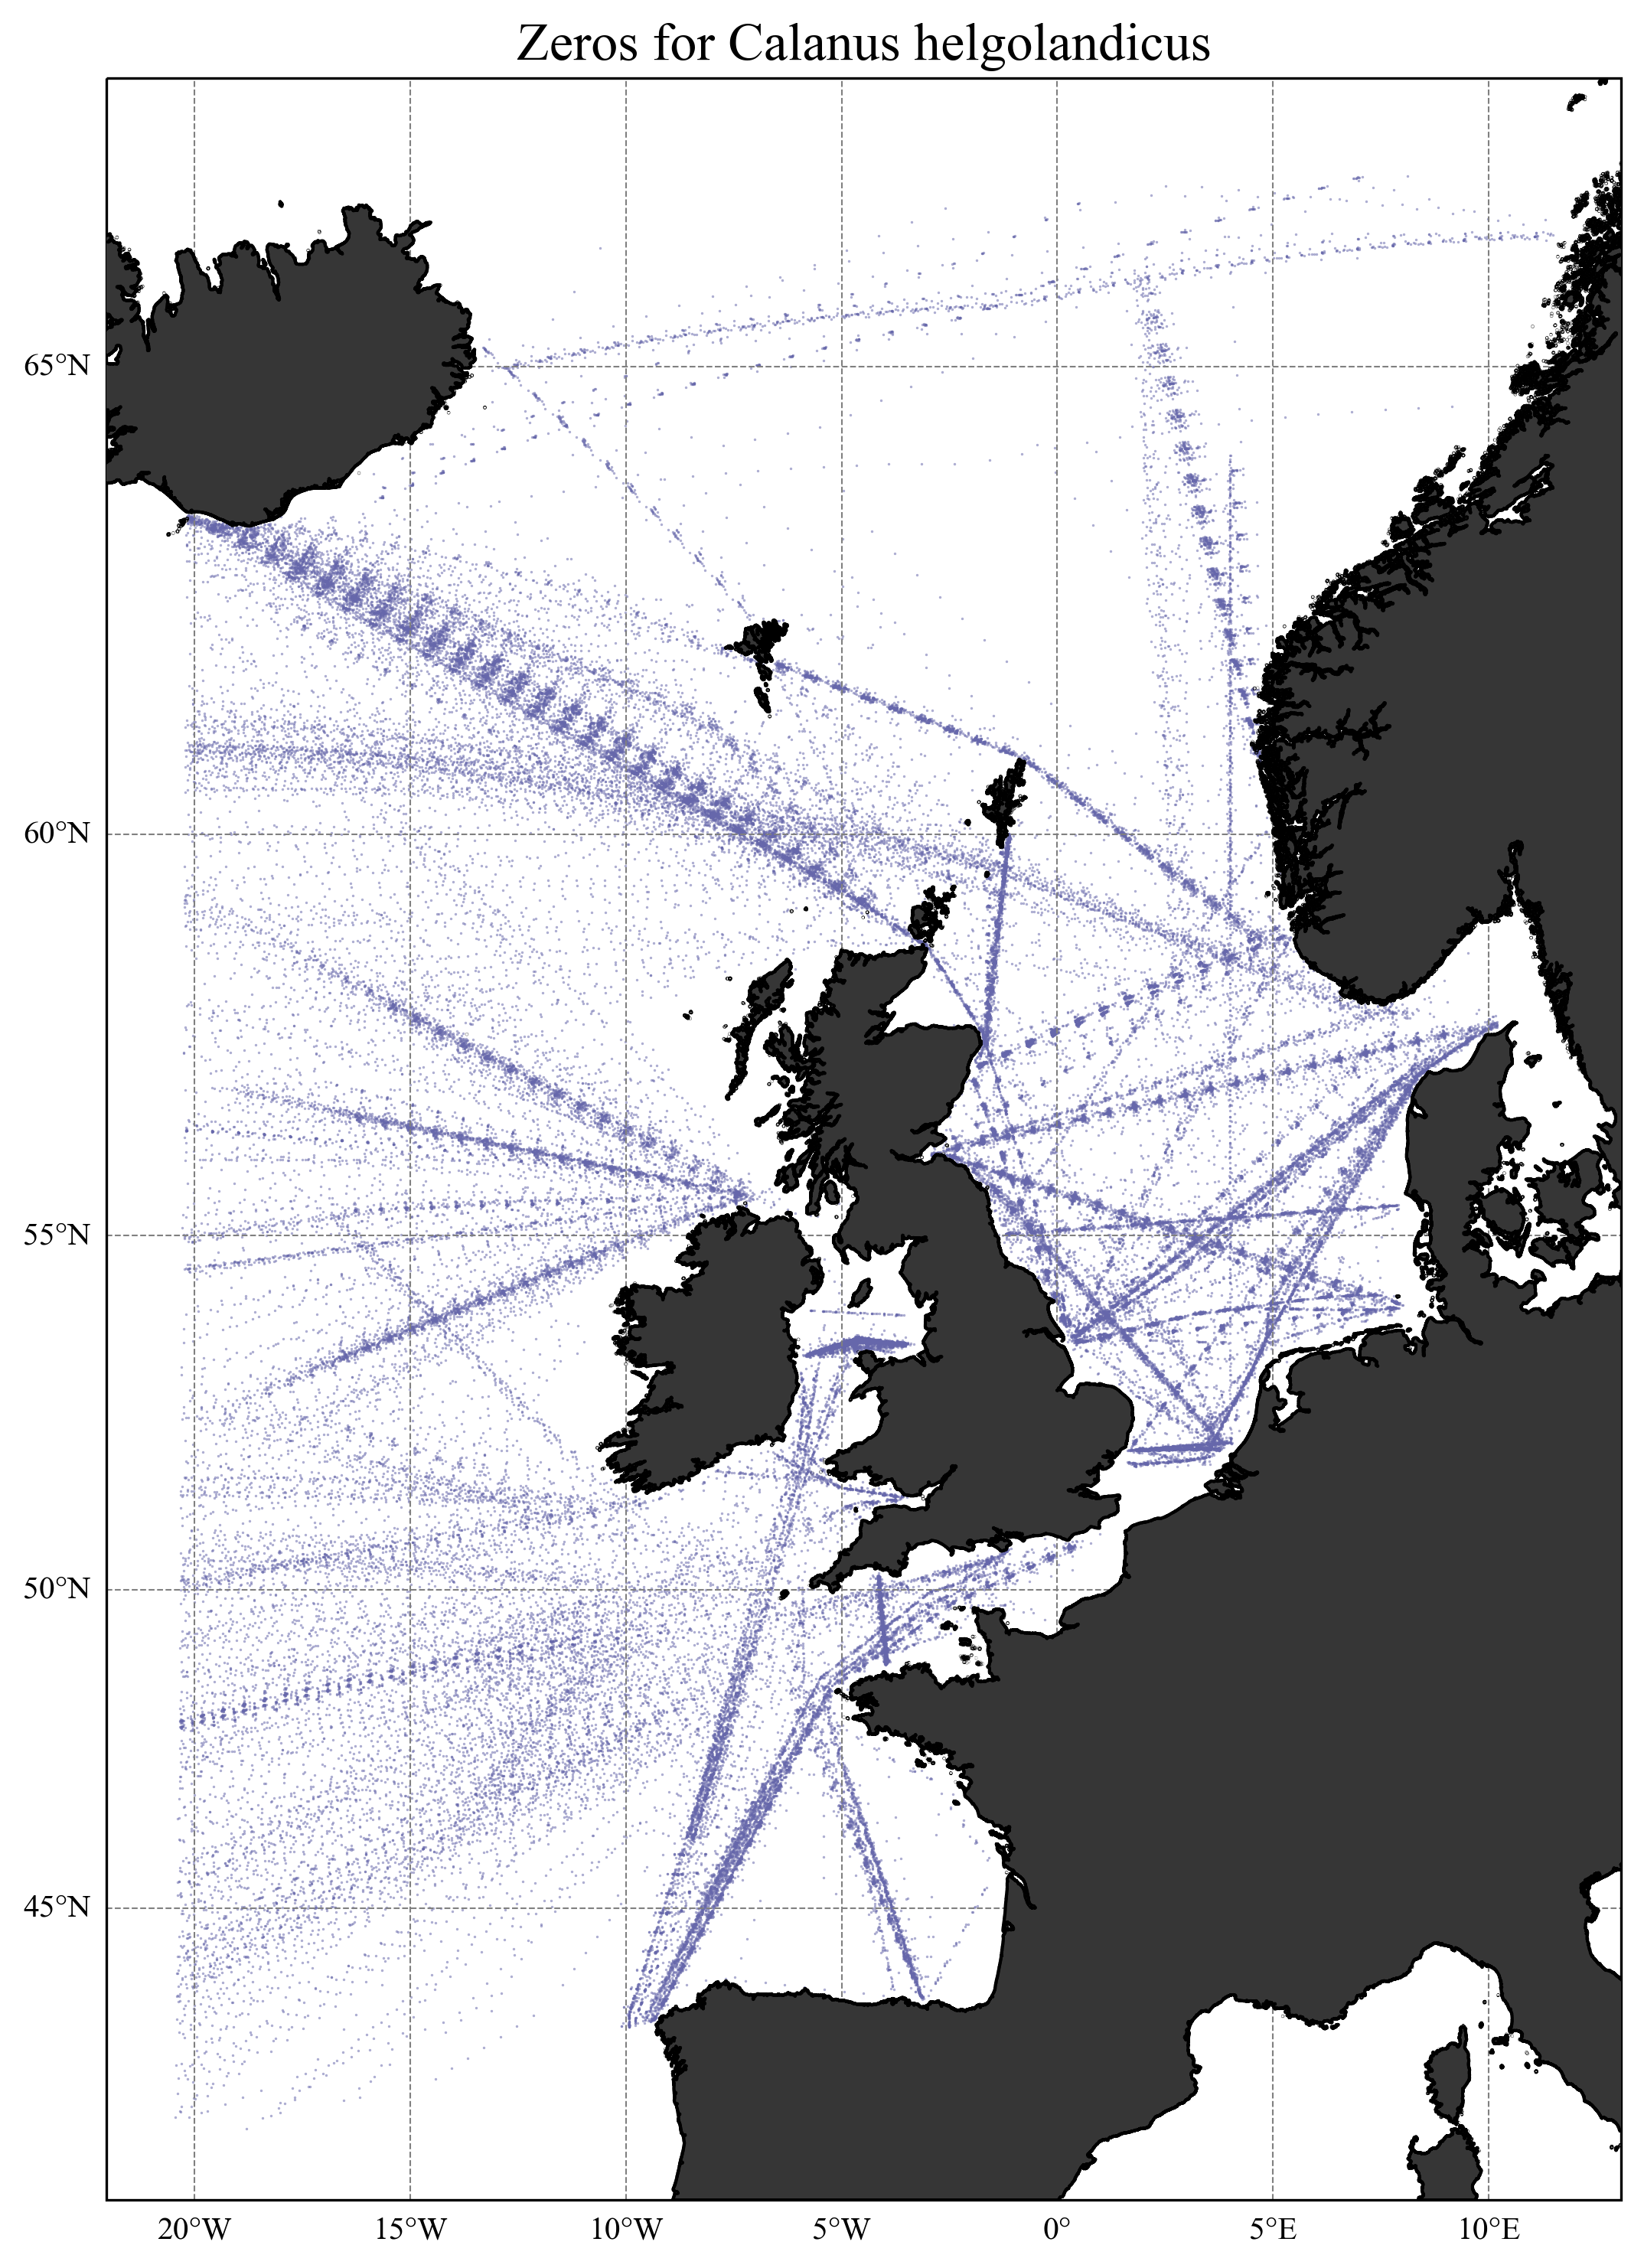

In [23]:
zerosloc1 = findall(calanus_finmarchicus .== 0.)
lonz1 = lon[zerosloc1]
latz1 = lat[zerosloc1]
zerosloc2 = findall(calanus_helgolandicus .== 0.)
lonz2 = lon[zerosloc2]
latz2 = lat[zerosloc2]

fig = plt.figure(figsize=(12, 12))
ax = plt.subplot(111, projection=mainproj)
#ax.scatter(0, 0, s=2, lw=.1, alpha=.95, color=mycolor, transform=datacrs, label="0's for Calanus finmarchicus")
#ax.scatter(0, 0, s=2, lw=.1, alpha=.95, color="#FF9935", transform=datacrs, label="0's for Calanus helgolandicus")
ax.scatter(lonz1, latz1, s=.5, lw=.1, alpha=.5, color=mycolor, transform=datacrs)
#ax.scatter(lonz2, latz2, s=.5, lw=.1, alpha=.5, color="#FF9935", transform=datacrs)
#ax.legend()

ax.add_feature(coast, facecolor="#363636", edgecolor="k", zorder=5)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=true,
                      linewidth=.5, color="gray", alpha=1, linestyle="--")
gl.top_labels = false
gl.right_labels = false
gl.xformatter = lon_formatter
gl.yformatter = lat_formatter
gl.xlabel_style = Dict("size" => 10)
gl.ylabel_style = Dict("size" => 10)
ax.set_title("Zeros for Calanus finmarchicus")

plt.savefig(joinpath(figdir, "zeros_calanus_finmarchicus3.jpg"), dpi=300, bbox_inches="tight")

plt.close()

fig = plt.figure(figsize=(12, 12))
ax = plt.subplot(111, projection=mainproj)
ax.scatter(lonz2, latz2, s=.5, lw=.1, alpha=.5, color=mycolor, transform=datacrs)

ax.add_feature(coast, facecolor="#363636", edgecolor="k", zorder=5)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=true,
                      linewidth=.5, color="gray", alpha=1, linestyle="--")
gl.top_labels = false
gl.right_labels = false
gl.xformatter = lon_formatter
gl.yformatter = lat_formatter
gl.xlabel_style = Dict("size" => 10)
gl.ylabel_style = Dict("size" => 10)
ax.set_title("Zeros for Calanus helgolandicus")

plt.savefig(joinpath(figdir, "zeros_calanus_helgolandicus3.jpg"), dpi=300, bbox_inches="tight")

plt.show()

In [24]:
length(lonz1)/length(lon), length(latz2)/length(lat)

(0.7259951559271474, 0.6285184526334515)

#### Calanus helgolandicus

In [25]:
countmin = 5
fig = plt.figure(figsize=(12, 12))
ax = plt.subplot(111, projection=mainproj)

ax.scatter(lon[calanus_helgolandicus .> 0], lat[calanus_helgolandicus .> 0], 
    s=.1, lw=.1, color="k", transform=datacrs)
indexplot = findall(calanus_helgolandicus .>= countmin)
scat = ax.scatter(lon[indexplot], lat[indexplot], s=1, c=calanus_helgolandicus[indexplot], 
                  cmap=plt.cm.inferno_r, vmin=countmin, vmax=50., transform=datacrs)

cb = plt.colorbar(scat, extend="both")

ax.add_feature(coast, facecolor="#363636", edgecolor="k", zorder=5)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=true,
                      linewidth=.5, color="gray", alpha=1, linestyle="--")
gl.top_labels = false
gl.right_labels = false
gl.xformatter = lon_formatter
gl.yformatter = lat_formatter
gl.xlabel_style = Dict("size" => 10)
gl.ylabel_style = Dict("size" => 10)
ax.set_title("Calanus helgolandicus observations")

plt.savefig(joinpath(figdir, "count_calanus_helgolandicus2.jpg"), dpi=300, bbox_inches="tight")

plt.close()

## Analysis
### 1. Basic analysis: all data together

In [92]:
L = 2.5
epsilon2 = 5.

5.0

In [93]:
@time f_finmarchicus, s = DIVAndrun(mask, (pm,pn), (xi,yi), (lon, lat), 
    calanus_finmarchicus .- mean(calanus_finmarchicus), (L, L), epsilon2);
@time f_helgolandicus, s = DIVAndrun(mask, (pm,pn), (xi,yi), (lon, lat), 
    calanus_helgolandicus .- mean(calanus_helgolandicus), (L, L), epsilon2);

  1.569881 seconds (2.05 M allocations: 1.037 GiB, 2.88% gc time)
  1.461622 seconds (2.05 M allocations: 1.037 GiB, 1.26% gc time)


In [98]:
function make_plot_analysis(longrid, latgrid, fieldinterp::Matrix{Float64}, 
        figtitle::String="", figname::String="")
    
    fig = plt.figure(figsize=(12, 12))
    ax = plt.subplot(111, projection=mainproj)
    pcm = ax.pcolormesh(longrid, latgrid, fieldinterp', 
            cmap=plt.cm.hot_r, vmin=0., vmax=50., transform=datacrs)
    cb = plt.colorbar(pcm, extend="max")

    ax.add_feature(coast, facecolor="#363636", edgecolor="k", zorder=5)

    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=true,
                          linewidth=.5, color="gray", alpha=1, linestyle="--")
    gl.top_labels = false
    gl.right_labels = false
    gl.xformatter = lon_formatter
    gl.yformatter = lat_formatter
    gl.xlabel_style = Dict("size" => 10)
    gl.ylabel_style = Dict("size" => 10)
    
    if length(figtitle) > 0
        ax.set_title(figtitle)
    end
    
    if length(figname) > 0
        plt.savefig(figname, dpi=300, bbox_inches="tight")
        plt.close()
    else
        plt.show()
    end
end

make_plot_analysis (generic function with 6 methods)

In [94]:
figname = joinpath(figdir, "analysis_calanus_helgolandicus.jpg")
make_plot_analysis(longrid, latgrid, calanus_helgolandicus, f_helgolandicus, 
    "Calanus helgolandicus analysis", figname)

figname = joinpath(figdir, "analysis_calanus_finmarchicus.jpg")
make_plot_analysis(longrid, latgrid, calanus_finmarchicus, f_finmarchicus, 
    "Calanus finmarchicus analysis", figname)

## Time analysis
### Yearly

In [75]:
"""
    create_nc_results(filename, lons, lats, field, speciesname)

Write a netCDF file `filename` with the coordinates `lons`, `lats` and the
heatmap `field`. `speciesname` is used for the 'title' attribute of the netCDF.

## Examples
```julia-repl
julia> create_nc_results("Bacteriastrum_interp.nc", lons, lats, field,
    "Bacteriastrum")
```
"""
function create_nc_results(filename::String, lons, lats, times, field,
                           speciesname::String="";
                           valex=-999.9,
                           varname::String = "heatmap",
                           long_name::String = "Heatmap",
						   domain::Array = [-180., 180., -90., 90.],
						   aphiaID::Int32 = 0
                           )
    Dataset(filename, "c") do ds

        # Dimensions
        ds.dim["lon"] = length(lons)
        ds.dim["lat"] = length(lats)
        ds.dim["time"] = Inf # unlimited dimension

        # Declare variables
		nccrs = defVar(ds, "crs", Int64, ())
    	nccrs.attrib["grid_mapping_name"] = "latitude_longitude"
    	nccrs.attrib["semi_major_axis"] = 6371000.0 ;
    	nccrs.attrib["inverse_flattening"] = 0 ;

        ncfield = defVar(ds, varname, Float64, ("lon", "lat"))
        ncfield.attrib["missing_value"] = Float64(valex)
        ncfield.attrib["_FillValue"] = Float64(valex)
		ncfield.attrib["units"] = "1"
        ncfield.attrib["long_name"] = long_name
		ncfield.attrib["coordinates"] = "lat lon"
		ncfield.attrib["grid_mapping"] = "crs" ;

        nctime = defVar(ds, "time", Int64, ("time",))
        nctime.attrib["missing_value"] = Float32(valex)
        nctime.attrib["units"] = "days since 1950-01-01 00:00:00"
        nctime.attrib["long_name"] = "time"
        
        nclon = defVar(ds,"lon", Float32, ("lon",))
        # nclon.attrib["missing_value"] = Float32(valex)
        nclon.attrib["_FillValue"] = Float32(valex)
        nclon.attrib["units"] = "degrees_east"
        nclon.attrib["long_name"] = "Longitude"
		nclon.attrib["standard_name"] = "longitude"
		nclon.attrib["axis"] = "X"
		nclon.attrib["reference_datum"] = "geographical coordinates, WGS84 projection"
		nclon.attrib["valid_min"] = -180.0 ;
		nclon.attrib["valid_max"] = 180.0 ;

        nclat = defVar(ds,"lat", Float32, ("lat",))
        # nclat.attrib["missing_value"] = Float32(valex)
        nclat.attrib["_FillValue"] = Float32(valex)
        nclat.attrib["units"] = "degrees_north"
		nclat.attrib["long_name"] = "Latitude"
		nclat.attrib["standard_name"] = "latitude"
		nclat.attrib["axis"] = "Y"
		nclat.attrib["reference_datum"] = "geographical coordinates, WGS84 projection"
		nclat.attrib["valid_min"] = -90.0 ;
		nclat.attrib["valid_max"] = 90.0 ;

        # Global attributes
		ds.attrib["Species_scientific_name"] = speciesname
		ds.attrib["Species_aphiaID"] = aphiaID
		ds.attrib["title"] = "$(long_name) based on presence/absence of $(speciesname)"
		ds.attrib["institution"] = "GHER - University of Liege, MBA"
		ds.attrib["source"] = "Spatial interpolation of presence/absence data"
        ds.attrib["project"] = "EMODnet Biology Phase IV"
        ds.attrib["comment"] = "Original data prepared by P. Helaouet"
        ds.attrib["data_authors"] = "Pierre Helaouet <pihe@MBA.ac.uk>"
        ds.attrib["processing_authors"] = "C. Troupin <ctroupin@uliege>, A. Barth <a.barth@uliege.be>"
		ds.attrib["publisher_name"] = "VLIZ"
		ds.attrib["publisher_url"] = "http://www.vliz.be/"
		ds.attrib["publisher_email"] = "info@vliz.be"
        ds.attrib["created"] = Dates.format(Dates.now(), "yyyy-mm-dd HH:MM:SS")
		ds.attrib["geospatial_lat_min"] = domain[3]
		ds.attrib["geospatial_lat_max"] = domain[4]
		ds.attrib["geospatial_lon_min"] = domain[1]
		ds.attrib["geospatial_lon_max"] = domain[2]
		ds.attrib["geospatial_lat_units"] = "degrees_north"
		ds.attrib["geospatial_lon_units"] = "degrees_east"
		ds.attrib["license"] = "GNU General Public License v2.0"
		ds.attrib["citation"] = "to be filled"
		ds.attrib["acknowledgement"] = "to be filled"
		ds.attrib["tool"] = "DIVAnd"
		ds.attrib["tool_version"] = "2.7.6"
		ds.attrib["tool_doi"] = "10.5281/zenodo.4306494"
		ds.attrib["language"] = "Julia 1.7.0"
		ds.attrib["Conventions"] = "CF-1.7"
		ds.attrib["netcdf_version"] = "4"

        # Define variables
        ncfield[:] = field
        nctime[:] = times
        nclon[:] = lons
        nclat[:] = lats;

    end
end;

In [102]:
for yyyy in 1959:2018
    goodyear = findall(year .== yyyy)
    @info(length(goodyear))
    
    @time f_finmarchicus, s = DIVAndrun(mask, (pm,pn), (xi,yi), (lon[goodyear], lat[goodyear]), 
        calanus_finmarchicus[goodyear] .- mean(calanus_finmarchicus[goodyear]), (L, L), epsilon2);
    @time f_helgolandicus, s = DIVAndrun(mask, (pm,pn), (xi,yi), (lon[goodyear], lat[goodyear]), 
        calanus_helgolandicus[goodyear] .- mean(calanus_helgolandicus[goodyear]), (L, L), epsilon2);
    
    figname = joinpath(figdir, "analysis_calanus_finmarchicus_$(yyyy).jpg")
    make_plot_analysis(longrid, latgrid, f_finmarchicus .+ mean(calanus_finmarchicus[goodyear]), 
        "Calanus finmarchicus analysis ($(yyyy))", figname)
    
    figname = joinpath(figdir, "analysis_calanus_helgolandicus_$(yyyy).jpg")
    make_plot_analysis(longrid, latgrid, f_helgolandicus .+ mean(calanus_helgolandicus[goodyear]), 
        "Calanus helgolandicus analysis ($(yyyy))", figname)

    create_nc_results(joinpath(resdir, "finmarchicus_$(yyyy).nc"), 
                  longrid, latgrid, (Dates.Date(yyyy, 1, 1) - Dates.Date(1950, 1, 1)).value, 
                  f_finmarchicus .+ mean(calanus_finmarchicus[goodyear]), 
                  "Calanus finmarchicus"; valex=-999.9, 
                  varname="abundance",
                  long_name="Abundance of Calanus finmarchicus",
                  domain=dom,
                  aphiaID=Int32(104464)
               )
        
        
    create_nc_results(joinpath(resdir, "helgolandicus_$(yyyy).nc"), 
              longrid, latgrid, (Dates.Date(yyyy, 1, 1) - Dates.Date(1950, 1, 1)).value, 
              f_helgolandicus .+ mean(calanus_helgolandicus[goodyear]), 
              "Calanus helgolandicus"; valex=-999.9, 
              varname="abundance",
              long_name="Abundance of Calanus helgolandicus",
              domain=dom,
              aphiaID=Int32(104466)
           )
        
    
end

  1.345824 seconds (35.56 k allocations: 884.143 MiB, 0.72% gc time)
  1.320817 seconds (35.56 k allocations: 884.143 MiB, 0.65% gc time)
  1.193950 seconds (34.96 k allocations: 884.084 MiB, 0.57% gc time)
  1.334209 seconds (34.96 k allocations: 884.084 MiB, 0.37% gc time)
  1.276573 seconds (35.82 k allocations: 884.175 MiB, 3.50% gc time)
  1.593305 seconds (35.82 k allocations: 884.175 MiB, 25.66% gc time)
  1.204472 seconds (38.37 k allocations: 884.426 MiB, 0.79% gc time)
  1.192212 seconds (38.37 k allocations: 884.426 MiB, 0.39% gc time)
  1.270380 seconds (36.97 k allocations: 884.296 MiB, 0.52% gc time)
  1.438190 seconds (36.97 k allocations: 884.296 MiB, 0.39% gc time)
  1.269493 seconds (38.25 k allocations: 884.452 MiB, 0.35% gc time)
  1.236954 seconds (38.25 k allocations: 884.452 MiB, 0.50% gc time)
  1.496909 seconds (41.35 k allocations: 884.707 MiB, 5.00% gc time)
  1.670943 seconds (41.36 k allocations: 884.707 MiB, 23.45% gc time)
  1.493894 seconds (36.38 k allo

┌ Info: 2364
└ @ Main In[102]:3
┌ Info: 2321
└ @ Main In[102]:3
┌ Info: 2382
└ @ Main In[102]:3
┌ Info: 2564
└ @ Main In[102]:3
┌ Info: 2465
└ @ Main In[102]:3
┌ Info: 2556
└ @ Main In[102]:3
┌ Info: 2777
└ @ Main In[102]:3
┌ Info: 2422
└ @ Main In[102]:3
┌ Info: 2679
└ @ Main In[102]:3
┌ Info: 2489
└ @ Main In[102]:3
┌ Info: 2863
└ @ Main In[102]:3
┌ Info: 2701
└ @ Main In[102]:3
┌ Info: 2964
└ @ Main In[102]:3
┌ Info: 2808
└ @ Main In[102]:3
┌ Info: 2788
└ @ Main In[102]:3
┌ Info: 2600
└ @ Main In[102]:3
┌ Info: 2490
└ @ Main In[102]:3
┌ Info: 2361
└ @ Main In[102]:3
┌ Info: 2267
└ @ Main In[102]:3
┌ Info: 1841
└ @ Main In[102]:3
┌ Info: 1925
└ @ Main In[102]:3
┌ Info: 2047
└ @ Main In[102]:3
┌ Info: 2141
└ @ Main In[102]:3
┌ Info: 2192
└ @ Main In[102]:3
┌ Info: 2505
└ @ Main In[102]:3
┌ Info: 2219
└ @ Main In[102]:3
┌ Info: 2482
└ @ Main In[102]:3
┌ Info: 2493
└ @ Main In[102]:3
┌ Info: 2052
└ @ Main In[102]:3
┌ Info: 2107
└ @ Main In[102]:3
┌ Info: 1999
└ @ Main In[102]:3
┌ Info: 